In [13]:
# wspinaczka 2
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import plot

from itertools import permutations
data_path = "dane/"

In [14]:
#data_path = "dane/"
#df = pd.read_csv(os.path.join(data_path, "dane_spr1.csv"), sep=';')
df = pd.read_excel(os.path.join(data_path, "dane1.xlsx"))

In [15]:
df_backup = df
df

,Zadanie,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10
0,1,8,97,14,74,75,27,69,65,89,83
1,2,77,49,17,29,43,98,28,21,41,3
2,3,73,33,31,77,70,62,95,60,16,99
3,4,91,48,37,14,11,17,38,72,7,87
4,5,96,68,85,30,64,35,89,4,84,60
5,6,10,36,84,14,88,71,19,85,53,92
6,7,58,66,7,48,94,94,6,47,56,75
7,8,70,6,54,1,9,58,52,80,71,53
8,9,42,54,40,4,29,77,70,71,40,30
9,10,21,16,95,71,58,29,4,26,17,59


In [16]:
def get_KR(df=df):
    if len(df) <= 0:
        return 0
    elif len(df) == 1:
        return int(df.sum(axis=1))

    obrobione = df.copy()
    obrobione["M1"] = df["M1"].cumsum() # TODO
    obrobione.iloc[1] = df.iloc[1].cumsum()
    
    for i in range(2, len(obrobione)):
        for j in range(2, len(obrobione.iloc[1])):
            max_val = max(int(obrobione.iloc[[i-1], [j]].values),
                             int(obrobione.iloc[[i], [j-1]].values))
            obrobione.iloc[[i], [j]] = max_val + df.iloc[[i], [j]]
    wartosc = int(obrobione.iloc[[-1], [-1]].values)
    
    return wartosc

# wartosc to jest wskażnik który teraz optymalizujemy

In [17]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
#def get_KR(df = df):
 #   c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
  #  KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
   # return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# wyszukiwanie listy sąsiadów
def get_neighbours(idx, neighbours_count = 10, df = df):
    N = neighbours_count
    # Idea sąsiedztwa dla N = 6 i idx = n E <N/2 ; L-N/2>
    # idx = X, sąsiad = 0, nie sąsiad = -
    # nr_indeksu | ... | n-4 | n-3 | n-2 | n-1 |  n  | n+1 | n+2 | n+3 | n+4 | ... |
    # sasiedztwo |  -  |  -  |  0  |  0  |  0  |  X  |  0  |  0  |  0  |  -  |  -  |
    
    L = len(df) - 1 
    idx_prev = idx # indeks dla ktorego szukamy sasiadow
    N_half = N//2 # polowa wartosci N
    
    
    # Idea sąsiedztwa dla N = 6 i idx = n < N/2
    # idx = X, sąsiad = 0, nie sąsiad = -
    # przykład n = 2
    # nr_indeksu |  0  |  1  | n=2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | ... |
    # sasiedztwo |  0  |  0  |  X  |  0  |  0  |  0  |  0  |  -  |  -  |  -  |  -  |
    # skoro nie mozemy znaleźć wystarczająco dużo sąsiadów po lewej, 
    # szukamy dodatkowego po prawej
    if idx < N_half:
        idx = N_half
    # idea sąsiedztwa z ograniczeniem z prawej jest analogiczna do tej z ograniczeniem z lewej
    elif idx > L - N_half:
        idx = L - N_half
    output = list(range(idx - N_half, idx + N_half + 1))
    # usuwanie idx z output
    # TODO: na pewno da się to zrobić prościej
    rm_idx = output.index(idx_prev)
    output = np.array(output)
    output = np.delete(output, rm_idx)
    return output

def calculate_improvements(KR_before, idx, neighbours, improvements, df = df):
    for neighbour, improvement in zip(
        neighbours, 
        np.nditer(improvements, op_flags = ['readwrite'])
    ):
        swap(idx, neighbour)
        improvement[...] = np.float64(get_KR(df) - KR_before)
        swap(idx, neighbour)
        
def search_for_the_best_neighbour(neighbours, improvements):
    if improvements.min() > 0:
        return False
    idx_min = improvements.argmin() # index najmniejszego elementu
    return neighbours[idx_min]

def swap(idx_1, idx_2, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx_1], df.iloc[idx_2] = df.iloc[idx_2].copy(), df.iloc[idx_1].copy()
    
def move(idx_1, idx_2, df=df):
    swap(idx_1, idx_2) # ruch
    
def plot_optimalization(optimalization):
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")

In [18]:
def hill_climbing_algorithm(
    number_of_iterations = 1, 
    break_counter = 1, 
    neighbours_count = 5,
    starting_index = np.random.randint(len(df))
):
    KR_before = get_KR(df) # początkowa wartość kombinacji
    optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
    optimalization = optimalization.append({
                    "Wartosc kombinacji": KR_before
                }, ignore_index=True)
    improvements = np.zeros(neighbours_count)
    idx = starting_index
    
    while number_of_iterations and break_counter:
        print(f"{number_of_iterations} iterations left")
        neighbours = get_neighbours(idx, neighbours_count=neighbours_count) # lista sąsiadów
        # obliczanie potencjalnych ulepszeń dla sąsiadów
        calculate_improvements(KR_before, idx, neighbours, improvements)
        # wyszukanie sąsiada dla którego ulepszenie będzie największe
        best_neighbour = search_for_the_best_neighbour(neighbours, improvements)

        # jeżeli istnieje sąsiad po zamianie z którym ulepszymy kombinacje
        if best_neighbour:
            # zamiana miejscami z sąsiadem
            move(idx, best_neighbour)
            # obliczanie obecnej kombinacji
            KR_now = get_KR(df)
            # kolejna iteracja rozpoczyna się od miejsca na które wskoczył idx
            idx = best_neighbour  
            # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
            optimalization = optimalization.append({
                "Wartosc kombinacji": KR_now
            }, ignore_index=True)
            
            KR_before = KR_now
            number_of_iterations -= 1
        else:
            break_counter -= 1
            
    order = df["Zadanie"]
    
    return order, optimalization

In [ ]:
if __name__ == '__main__':
    
    # generowanie 50 elemntowej permutacji indeksów początkowych dla multistartu
    arr = np.arange(len(df))
    np.random.shuffle(arr)
    arr = arr.reshape((25,2))
    arr = arr[0]
    starting_points = arr # 50 punktów startowych lista intów
    KR_before = get_KR(df)
    order_plot=pd.DataFrame(columns=["Wartosc kombinacji"])
    order_plot = order_plot.append({
                    "Wartosc kombinacji": KR_before
                }, ignore_index=True)
    order = pd.DataFrame()
    value_of_order = np.inf
    
    for point in starting_points:
        new_order, new_optimalization = hill_climbing_algorithm(
                number_of_iterations=20,
                break_counter=1,
                neighbours_count=4,
                starting_index=point
            )
        new_value = new_optimalization["Wartosc kombinacji"].iloc[-1] # ostatnia wartość
        if new_value < value_of_order:
            order = new_order.copy()
            value_of_order = new_value
            order_plot=order_plot.append(order_plot.append({
                    "Wartosc kombinacji": value_of_order
                }, ignore_index=True))
    
    #plot_optimalization(new_optimalization)
    #new_optimalization["Wartosc kombinacji"].iloc[-1]
    

20 iterations left
19 iterations left
18 iterations left
20 iterations left
19 iterations left
18 iterations left
17 iterations left
16 iterations left
15 iterations left
14 iterations left
13 iterations left
12 iterations left
11 iterations left
10 iterations left
9 iterations left
8 iterations left
7 iterations left
6 iterations left
5 iterations left
4 iterations left
3 iterations left
2 iterations left
1 iterations left


In [21]:
value_of_order

3751

In [23]:
order

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    29
17    17
18    19
19    18
20    20
21    22
22    21
23    24
24    23
25    26
26    25
27    28
28    27
29    31
30    34
31    37
32    30
33    40
34    32
35    35
36    33
37    36
38    39
39    38
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
49    50
Name: Zadanie, dtype: int64

C:\Users\Bartek Kalata\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


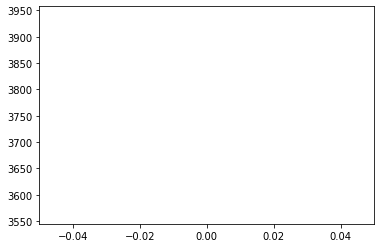

In [24]:
plot_optimalization(new_optimalization)

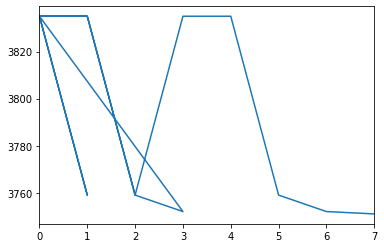

In [25]:
plot_optimalization(order_plot)

In [ ]:
#pd.to_csv()